# Kv 2.1 parameter extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
filebase = '/home/kernfel/Documents/Data/Oocytes/2018_05_03_%04d.atf'
fileno, fileno2, fileno3 = 0, 4, 5
savebase = filebase[:-4] % fileno + '-' + str(fileno3)
params = dict()
tres = 0.025 # Time of one sample in ms

In [3]:
rec = read_2channel_ATF(filebase % fileno)
rec2 = read_2channel_ATF(filebase % (fileno2))
rec3 = read_2channel_ATF(filebase % (fileno3))

## Sanity checks

To make sure we've got the right recordings, let's visualise the full trace stacks:

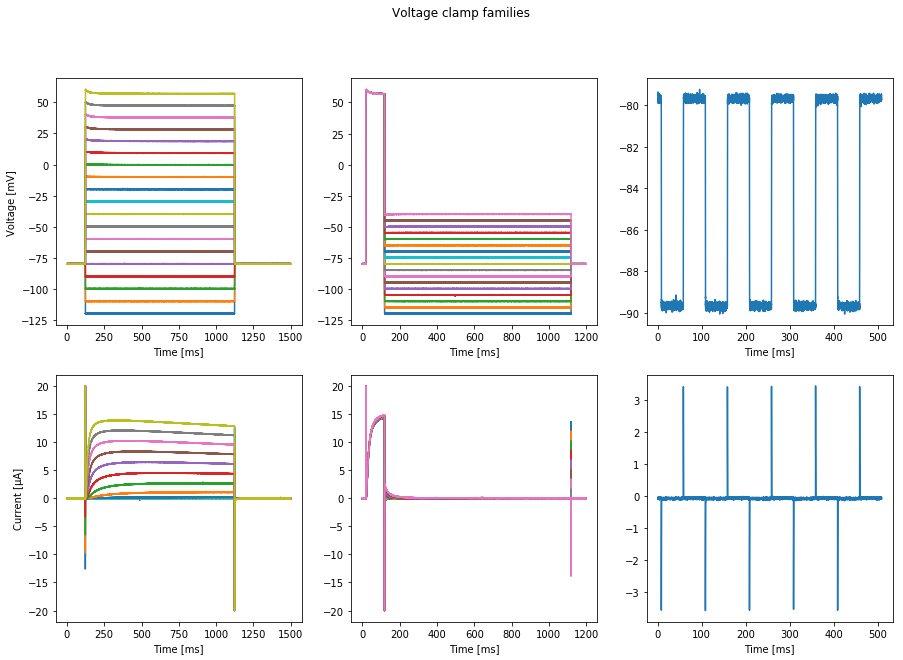

In [4]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Voltage clamp families')

t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres
t3 = np.arange(len(rec3.voltage[0])) * tres

def rawplot(ax, T, Y, ylabel=''):
    for y in Y:
        plt.plot(T, y)
    plt.xlabel('Time [ms]')
    plt.ylabel(ylabel)

rawplot(plt.subplot(2,3,1), t, rec.voltage, 'Voltage [mV]')
rawplot(plt.subplot(2,3,2), t2, rec2.voltage)
rawplot(plt.subplot(2,3,3), t3, rec3.voltage)

rawplot(plt.subplot(2,3,4), t, rec.current, u'Current [μA]')
rawplot(plt.subplot(2,3,5), t2, rec2.current)
rawplot(plt.subplot(2,3,6), t3, rec3.current)

fig.savefig(savebase + '.family.png')

Let's sanity check the step boundaries. The vertical lines should mark the exact beginning of the step and at least the end of the capacitive spike. Should the latter not coincide, the limits needs to be adjusted!

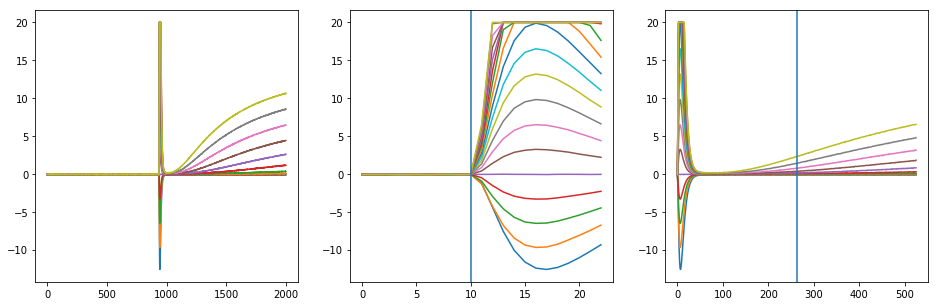

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5200, 44800)

# The true step time
rec_step_t0 = 4937

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
for I in rec.current:
    plt.plot(I[4000:6000])
    
plt.subplot(1,3,2)
for I in rec.current:
    plt.plot(I[4927:4950])
plt.axvline(rec_step_t0 - 4927)
    
plt.subplot(1,3,3)
for I in rec.current:
    plt.plot(I[rec_step_t0:rec_step_t0 + 2*(rec_limits[0]-rec_step_t0)])
plt.axvline(rec_limits[0] - rec_step_t0)

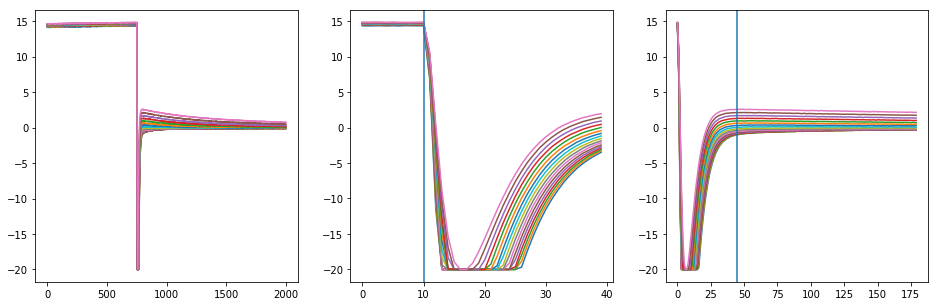

In [6]:
# The start and end of the step -- here, the first number is the true step time
rec2_limits = (4750, 10000)

# The cutoff for the tail current as used in the tail fitting procedure; this should mark the end of the capacitive spike
rec2_cut = get_tail_cut(rec2, rec2_limits[0])

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
for I in rec2.current:
    plt.plot(I[4000:6000])
    
plt.subplot(1,3,2)
for I in rec2.current:
    plt.plot(I[4740:4780])
plt.axvline(rec2_limits[0] - 4740)
    
plt.subplot(1,3,3)
for I in rec2.current:
    plt.plot(I[rec2_limits[0]:rec2_limits[0] + 4*(rec2_cut-rec2_limits[0])])
plt.axvline(rec2_cut-rec2_limits[0])

Finally, a sanity check for the third (capacitance) recording, showing a step down and the subsequent step up:

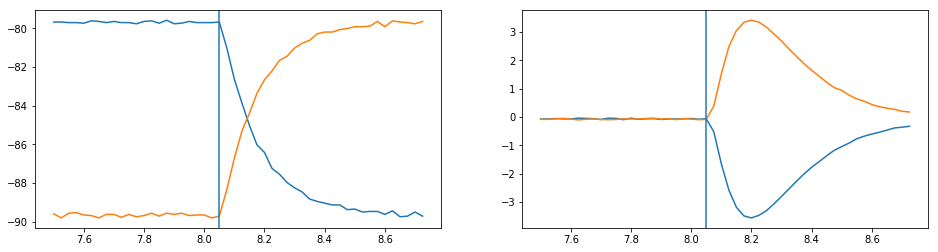

In [7]:
# Index of the first step
rec3_offset = 322

# Step spec
rec3_stepdur = 2000
rec3_nsteps = 10

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
for V in rec3.voltage:
    plt.plot(t3[300:350], V[300:350])
    plt.plot(t3[300:350], V[300+rec3_stepdur:350+rec3_stepdur])
plt.axvline(t3[rec3_offset])
plt.subplot(1,2,2)
for I in rec3.current:
    plt.plot(t3[300:350], I[300:350])
    plt.plot(t3[300:350], I[300+rec3_stepdur:350+rec3_stepdur])
plt.axvline(t3[rec3_offset])

## Measurements

### Leak current

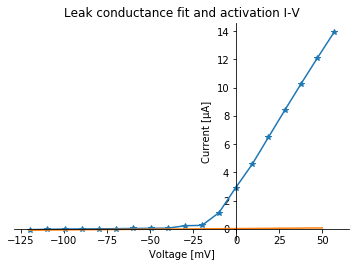

In [8]:
fig, ax = plt.subplots()
fit_leak(rec, params, ax, rec_limits)

plt.title('Leak conductance fit and activation I-V')
plt.savefig(savebase + '.leak_IV.png')

### Potassium current

analysis_helpers.py:94: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau)


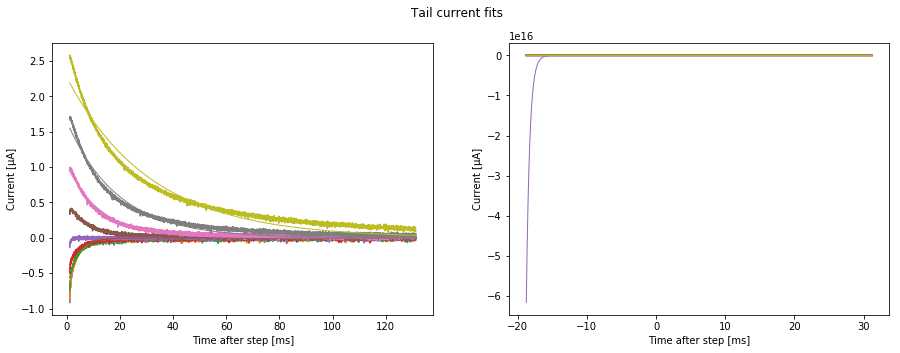

In [9]:
fit_tails(rec2, rec2_limits[0], rec2_limits[1], baseline = [np.median(I[40000:44000]) for I in rec2.current])

fig = plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plot_tail_fit(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

plt.subplot(1,2,2)
plot_tail_fit(rec2, params, 4000, 6000, tres, range(0, len(rec2.tails), 2))

fig.suptitle('Tail current fits')
fig.savefig(savebase + '.tail_fits.png')

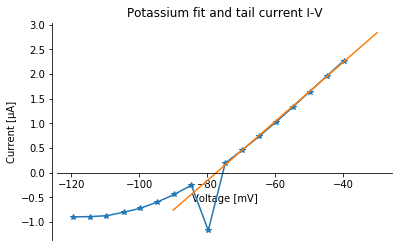

In [10]:
tail_t0 = [exp_decay(0, rec2.tau[i], rec2.a[i]) for i in range(len(rec2.tails))]

fig, ax = plt.subplots()
IVplot(tail_t0, rec2.tail_voltages, ax)

# Fit to the positive current values only
for i in range(len(tail_t0)-1, 0, -1):
    if tail_t0[i] < 0:
        tail_fit_from = i+1
        break

fit_IV(tail_t0[tail_fit_from:], rec2.tail_voltages[tail_fit_from:], params, 'K')

tail_plot_V = np.array([-90, -30])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

ax.set_title('Potassium fit and tail current I-V')
plt.savefig(savebase + '.tail_IV.png')

### Capacitance

In [11]:
params['C'] = fit_capacitance(rec3, tres, rec3_offset, rec3_stepdur)

In [12]:
f = open(savebase + '.params', 'w')

pstr = '\
g_leak:\t%(g_leak)f mS\n\
E_leak:\t%(E_leak)f mV\n\
g_K:\t%(g_K)f mS\n\
E_K:\t%(E_K)f mV\n\
C:\t%(C)f nF' % params

print pstr

f.write(pstr)
f.close()

g_leak:	0.000930 mS
E_leak:	-16.533410 mV
g_K:	0.060031 mS
E_K:	-77.284248 mV
C:	113.020653 nF
